In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


mnist = input_data.read_data_sets('./mnist/input_data/', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(10000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Extracting ./mnist/input_data/train-images-idx3-ubyte.gz
Extracting ./mnist/input_data/train-labels-idx1-ubyte.gz
Extracting ./mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/input_data/t10k-labels-idx1-ubyte.gz
Iter: 0
D loss: 1.934
G_loss: 1.769

Iter: 1000
D loss: 0.01117
G_loss: 10.66

Iter: 2000
D loss: 0.01582
G_loss: 9.651

Iter: 3000
D loss: 0.03902
G_loss: 5.762

Iter: 4000
D loss: 0.147
G_loss: 5.84

Iter: 5000
D loss: 0.2387
G_loss: 6.058

Iter: 6000
D loss: 0.2166
G_loss: 5.692

Iter: 7000
D loss: 0.3998
G_loss: 3.543

Iter: 8000
D loss: 0.3858
G_loss: 4.142

Iter: 9000
D loss: 0.4462
G_loss: 3.13



Extracting ./mnist/input_data/train-images-idx3-ubyte.gz
Extracting ./mnist/input_data/train-labels-idx1-ubyte.gz
Extracting ./mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/input_data/t10k-labels-idx1-ubyte.gz
Iter: 0; D loss: 1.324; G_loss: 0.4304
Iter: 1000; D loss: -4.039; G_loss: -0.1645
Iter: 2000; D loss: -2.699; G_loss: -0.6678
Iter: 3000; D loss: -2.525; G_loss: -0.8605
Iter: 4000; D loss: -2.15; G_loss: -0.8671
Iter: 5000; D loss: -2.273; G_loss: -1.095
Iter: 6000; D loss: -1.839; G_loss: -1.082
Iter: 7000; D loss: -2.026; G_loss: -1.27
Iter: 8000; D loss: -1.753; G_loss: -0.8659
Iter: 9000; D loss: -1.958; G_loss: -0.1803
Iter: 10000; D loss: -1.466; G_loss: -0.3171
Iter: 11000; D loss: -1.747; G_loss: -0.1145
Iter: 12000; D loss: -1.898; G_loss: -0.07585
Iter: 13000; D loss: -2.227; G_loss: 0.1022
Iter: 14000; D loss: -2.097; G_loss: 0.1746
Iter: 15000; D loss: -2.117; G_loss: 0.8968
Iter: 16000; D loss: -1.968; G_loss: 1.359
Iter: 17000; D loss: -1.764; G_lo

c:\users\floofy\appdata\local\programs\python\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter: 21000; D loss: -1.762; G_loss: 1.381
Iter: 22000; D loss: -1.865; G_loss: 1.412
Iter: 23000; D loss: -1.868; G_loss: 1.348
Iter: 24000; D loss: -1.846; G_loss: 1.204
Iter: 25000; D loss: -2.074; G_loss: 0.862
Iter: 26000; D loss: -1.735; G_loss: 0.9085
Iter: 27000; D loss: -1.738; G_loss: 1.324
Iter: 28000; D loss: -1.692; G_loss: 1.32
Iter: 29000; D loss: -1.771; G_loss: 1.292
Iter: 30000; D loss: -1.75; G_loss: 1.34
Iter: 31000; D loss: -1.712; G_loss: 1.49
Iter: 32000; D loss: -1.834; G_loss: 1.537
Iter: 33000; D loss: -1.744; G_loss: 1.728
Iter: 34000; D loss: -1.556; G_loss: 1.588
Iter: 35000; D loss: -1.565; G_loss: 1.819
Iter: 36000; D loss: -1.415; G_loss: 1.901
Iter: 37000; D loss: -1.521; G_loss: 2.112
Iter: 38000; D loss: -1.33; G_loss: 2.125
Iter: 39000; D loss: -1.387; G_loss: 2.209
Iter: 40000; D loss: -1.2; G_loss: 2.134
Iter: 41000; D loss: -1.403; G_loss: 2.36
Iter: 42000; D loss: -1.483; G_loss: 2.403
Iter: 43000; D loss: -1.602; G_loss: 2.535
Iter: 44000; D los

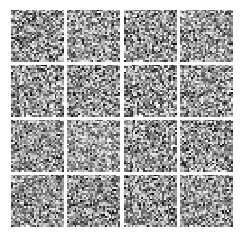

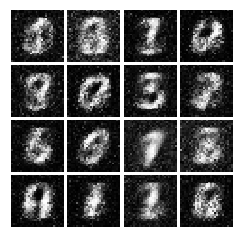

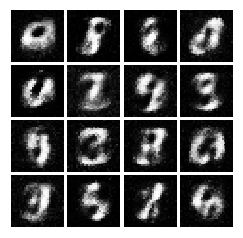

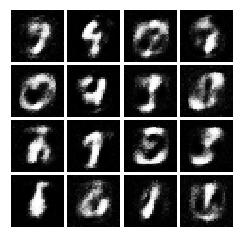

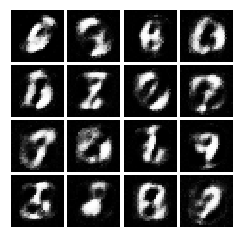

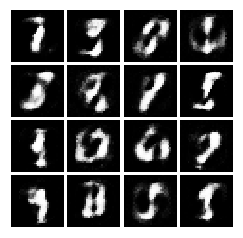

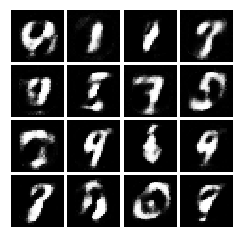

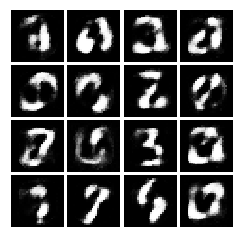

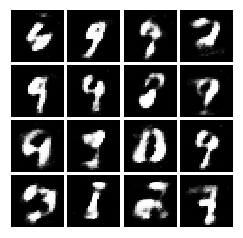

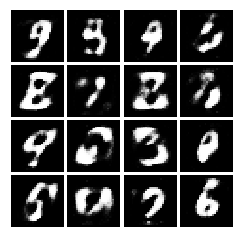

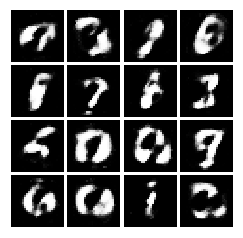

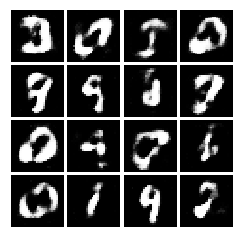

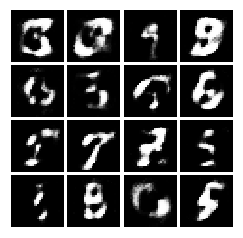

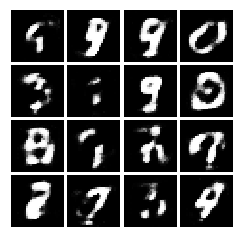

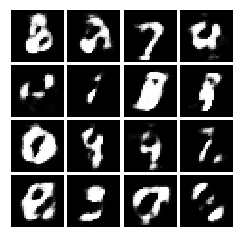

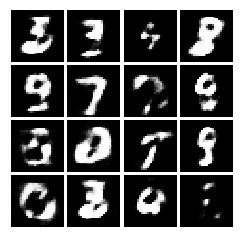

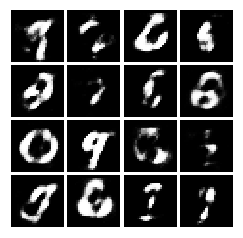

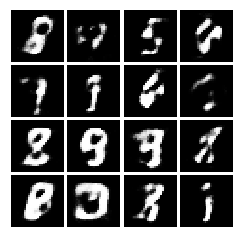

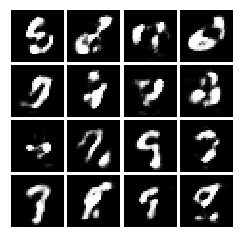

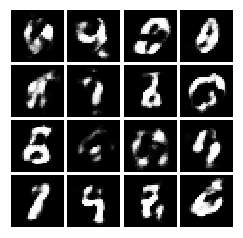

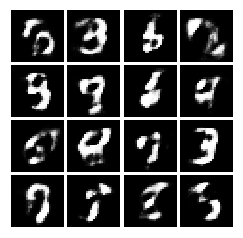

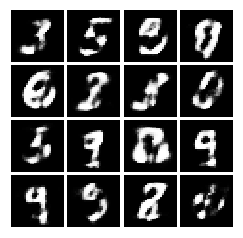

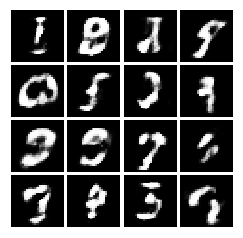

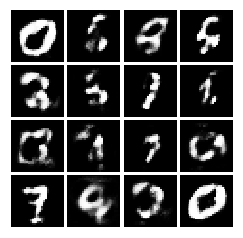

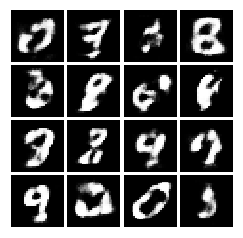

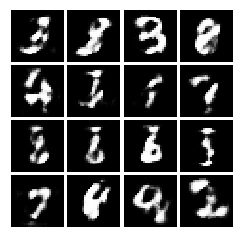

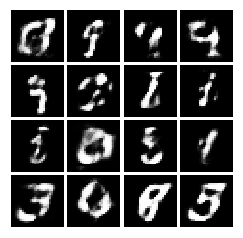

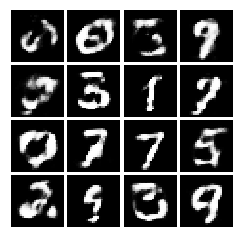

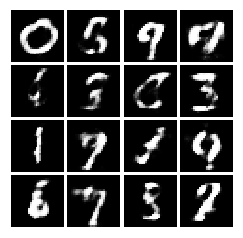

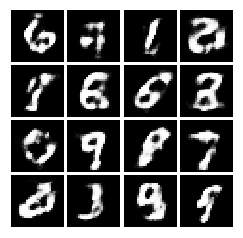

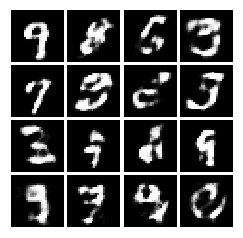

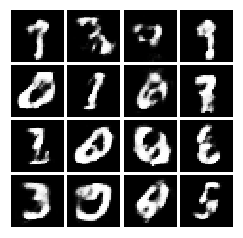

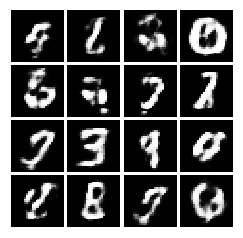

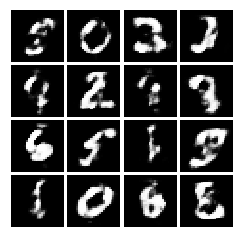

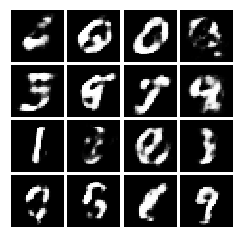

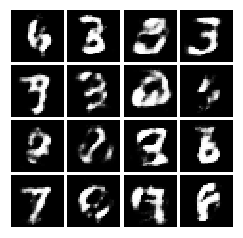

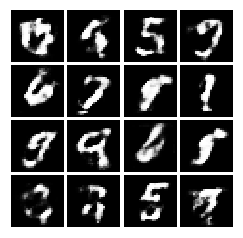

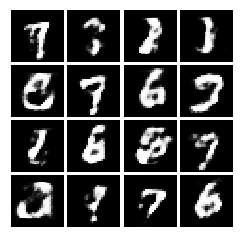

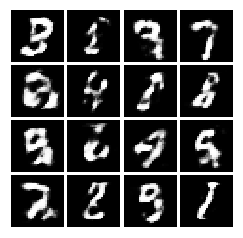

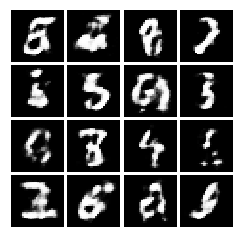

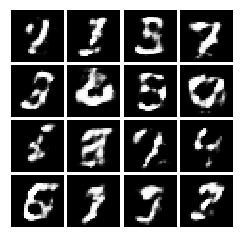

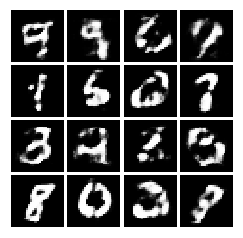

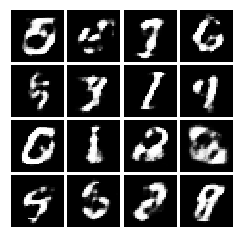

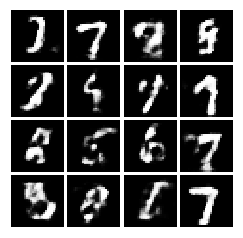

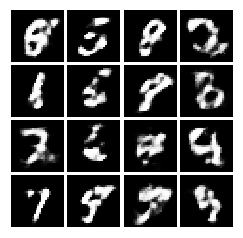

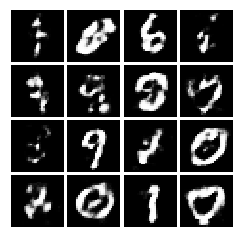

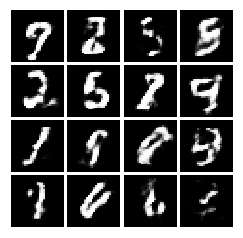

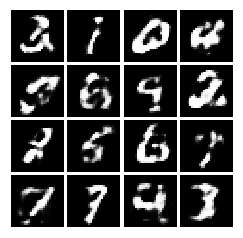

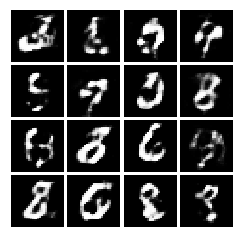

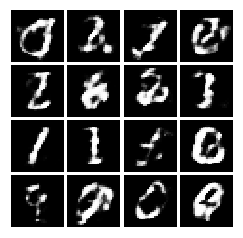

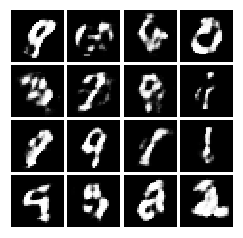

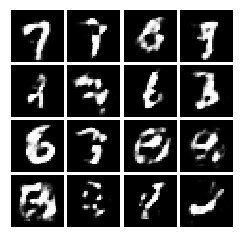

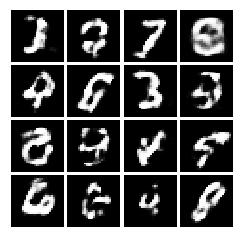

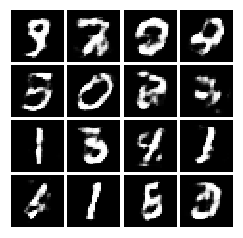

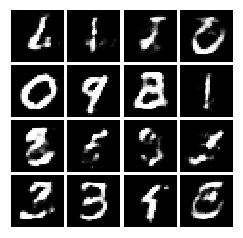

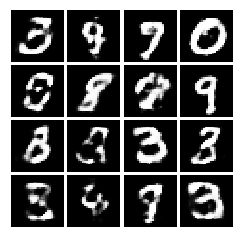

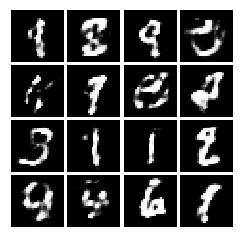

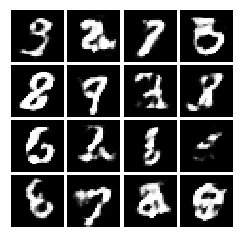

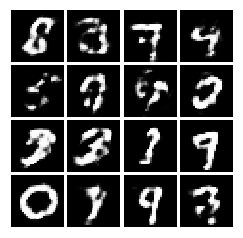

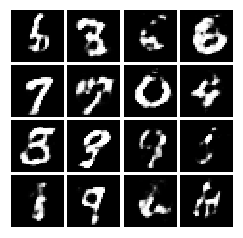

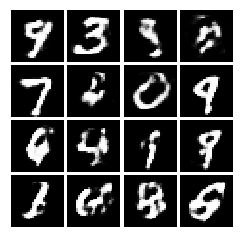

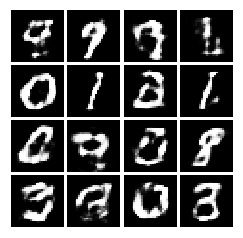

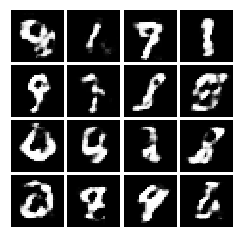

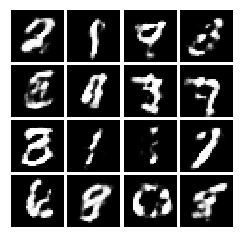

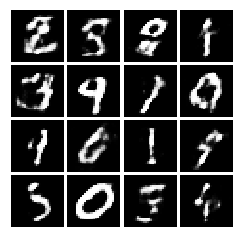

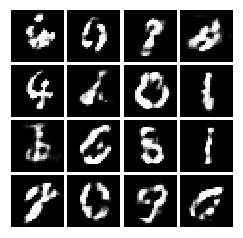

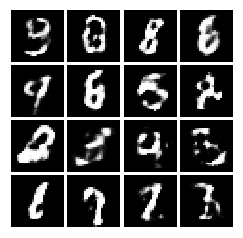

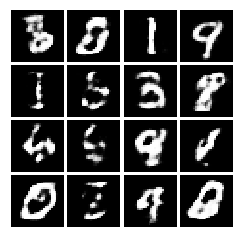

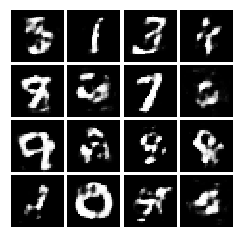

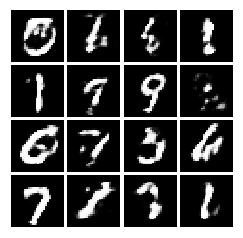

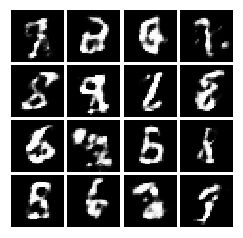

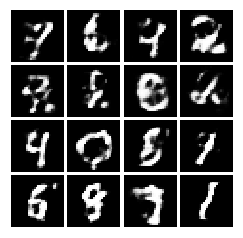

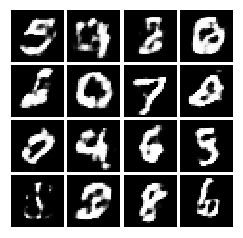

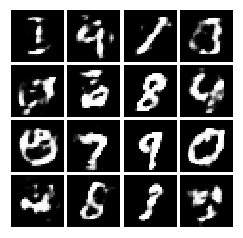

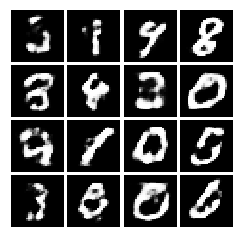

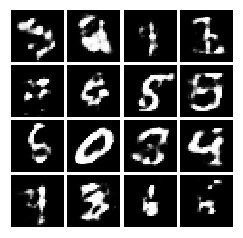

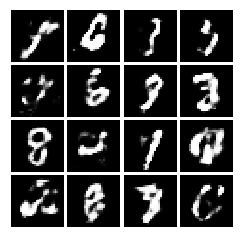

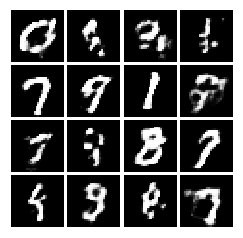

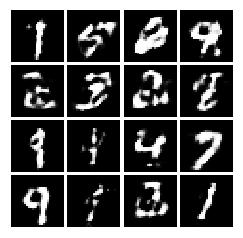

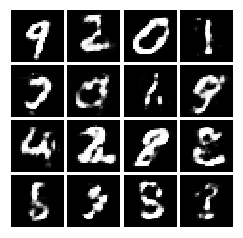

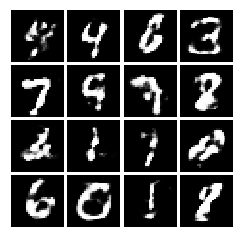

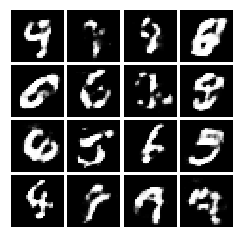

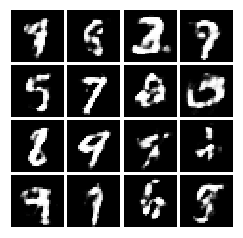

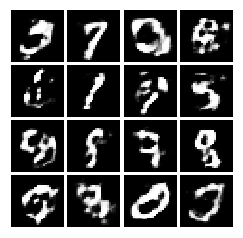

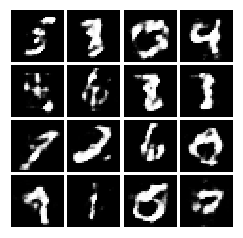

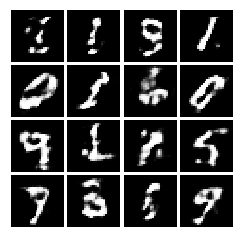

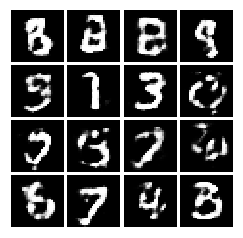

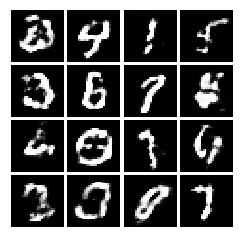

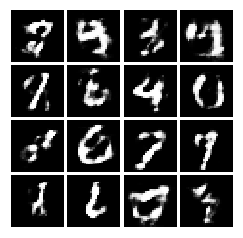

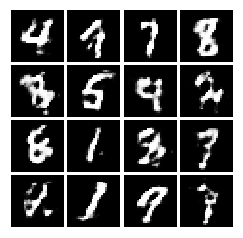

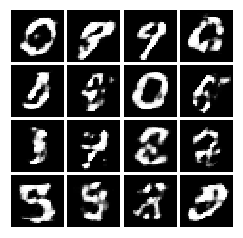

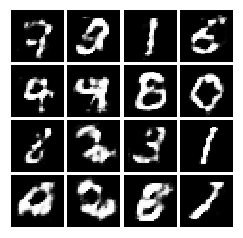

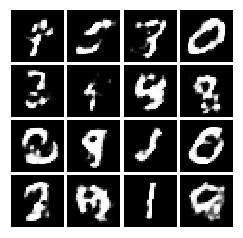

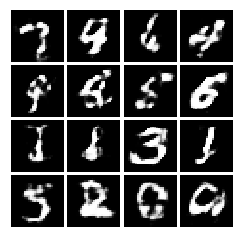

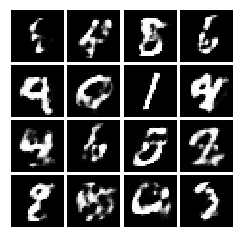

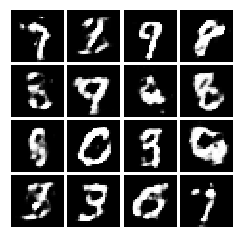

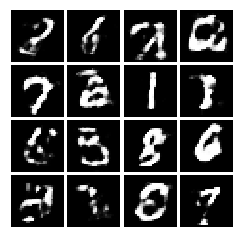

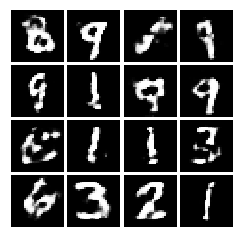

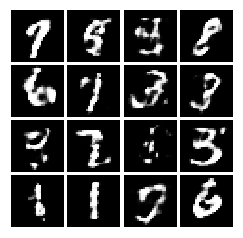

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


mb_size = 32
X_dim = 784
z_dim = 10
h_dim = 128
lam = 10
n_disc = 5
lr = 1e-4

mnist = input_data.read_data_sets('./mnist/input_data/', one_hot=True)

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def G(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob


def D(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    out = tf.matmul(D_h1, D_W2) + D_b2
    return out


G_sample = G(z)
D_real = D(X)
D_fake = D(G_sample)

eps = tf.random_uniform([mb_size, 1], minval=0., maxval=1.)
X_inter = eps*X + (1. - eps)*G_sample
grad = tf.gradients(D(X_inter), [X_inter])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=1))
grad_pen = lam * tf.reduce_mean((grad_norm - 1)**2)

D_loss = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) + grad_pen
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5)
            .minimize(G_loss, var_list=theta_G))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(100000):
    for _ in range(n_disc):
        X_mb, _ = mnist.train.next_batch(mb_size)

        _, D_loss_curr = sess.run(
            [D_solver, D_loss],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)}
        )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    if it % 1000 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})

            fig = plot(samples)
            plt.savefig('out/wgan/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
plt.close(fig)